In [2]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import os, sys

In [3]:
# upload a dataset 

file_path = os.path.join(sys.path[0], "dialogues_v3_Evgeny.xlsx")
df = pd.read_excel(file_path, header = 1, 
                   names = ['id', 'pagetitle', 'orig_user', 'reply_user', 'orig', 'reply',
       'disagreement', 'orig_id', 'reply_id', 'orig_toxicity',
       'orig_severe_toxicity', 'reply_toxicity', 'reply_severe_toxicity',
       'conv_id', 'COP', 'COP_flag', 'COP_why', 'FCG', 'FCG_flag',
       'FCG_why', 'RT', 'RT_flag', 'RT_why', 'PS',
       'PS_flag', 'PS_why', 'Overall comment', 'escalated'], index_col = 'id', convert_float = True)
df = df.convert_dtypes()

# choose appropriate columns. drop lines without disagreement.
df_ess = df[['orig', 'reply', 'COP', 'FCG', 'RT', 'PS']].dropna()
labels = ['COP', 'FCG', 'RT', 'PS']

 # Split sets by train+dev and test

In [4]:
from sklearn.model_selection import train_test_split
# Test and train data split
df_train, df_test = train_test_split(df_ess, random_state = 42)

# RoBERTa 

In [5]:
# Divide by train and test datasets
X_train = list(df_train['reply'])
X_test = list(df_test['reply'])
y_all_train = df_train[labels]
y_all_test = df_test[labels]
# example label
label = 'PS'
y_train = y_all_train[label].tolist()
y_test = y_all_test[label].tolist()
# Divide train by train and dev
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


In [6]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


In [7]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)


In [8]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))


In [14]:
from transformers import TFRobertaForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',         # output directory
    evaluation_strategy="steps",
    num_train_epochs=2,
    eval_steps = 50,                # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)



In [15]:
with training_args.strategy.scope():
    model = TFRobertaForSequenceClassification.from_pretrained('roberta-base')


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
trainer = TFTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


KeyboardInterrupt: 

In [ ]:
from datasets import load_metric

metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = TFTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)
trainer.evaluate()

In [20]:
output=trainer.predict(test_dataset)[0]

def get_prediction_labels(output):
    pred_labels = []
    for pair in output:
        if pair[0] > pair[1]:
            pred_labels.append(0)
        else:
            pred_labels.append(1)
    return pred_labels

pred = get_prediction_labels(output)

In [22]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(y_test,pred)
cm

array([[126,   0],
       [ 75,   0]])

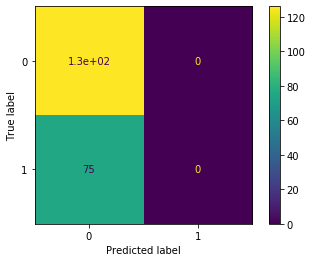

In [24]:
cmd = ConfusionMatrixDisplay(cm, display_labels = [0,1])
cmd.plot()

In [1]:
from s

0.005